In [66]:
from obspy import read
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch

In [68]:
model = torch.load('simple.pt')
model.eval()

SimpleNet(
  (conv_1): Conv1d(1, 16, kernel_size=(32,), stride=(2,), padding=(15,), padding_mode=reflect)
  (norm_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_1): GELU(approximate='none')
  (conv_2): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
  (norm_2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_2): GELU(approximate='none')
  (pool): AdaptiveAvgPool1d(output_size=256)
  (fc_1): Linear(in_features=256, out_features=1, bias=True)
)

In [75]:
def prepare_input(data):
    num_to_pad = chunk_size - (len(data) % chunk_size)
    padded_data = np.pad(data, (0, num_to_pad))
    
    windows = np.array(np.array_split(padded_data, len(padded_data) / chunk_size))
    return torch.from_numpy(windows.reshape(-1, 1, chunk_size)).float()

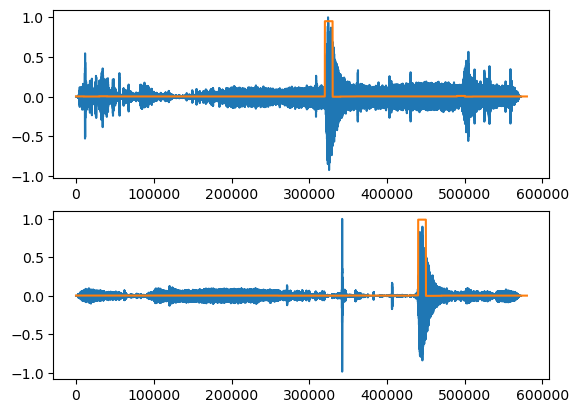

In [106]:
start = 1
num = 2
my_list = glob.glob('./data/lunar/test/data/*/*.mseed', recursive=True)[start:start+num]
# my_list = glob.glob('./data/lunar/training/data/*/*.mseed', recursive=True)

chunk_size = 10_000

divide_by = 1.5e-7

fig, ax = plt.subplots(num, 1)

for idx, filename in enumerate(my_list):
    file = read(filename)
    data = file[0].data
    ax[idx].plot(data / max(data))
    output = model(prepare_input(data / divide_by))
    projected_output = (torch.ones(chunk_size, output.squeeze().shape[0]) * output.squeeze()).T.reshape(-1).detach().numpy()
    ax[idx].plot(projected_output)
plt.show()

In [2]:
def get_chunks_from_file(filename):
    filename = './data/lunar/test/data/S12_GradeA/' + filename + '.csv'
    event_timestamp = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], timestamp_format)
    for i in range(0, 1000):
        chunk = pd.read_csv(filename, skiprows=(i*overlap + 1), nrows=window_size, names=('timestamp', '_rel', 'velocity'))
        if len(chunk) == 0:
            break

        first_timestamp = datetime.strptime(chunk.iloc[0]['timestamp'], timestamp_format)
        last_timestamp = datetime.strptime(chunk.iloc[-1]['timestamp'], timestamp_format)
        padded_signal = np.pad(chunk['velocity'], (0, self.window_size - len(chunk))) / 1.5e-07
        
        if (first_timestamp <= event_timestamp and last_timestamp >= event_timestamp):
            self.event_windows.append(padded_signal)
        else:
            self.non_event_windows.append(padded_signal)